
# QGAN: (Q-Net) + GAN (G-Net and D-Net)

More specifically, we'll use Q-GAN to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
import numpy as np

In [2]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.8.0
Default GPU Device: /device:GPU:0


>**Note:** Make sure you have OpenAI Gym cloned. Then run this command 'pip install -e gym/[all]'.

In [3]:
import gym
# Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [4]:
env.reset()
rewards, states, actions, dones = [], [], [], []
for _ in range(10):
    #env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    states.append(state)
    rewards.append(reward)
    actions.append(action)
    dones.append(done)
    #     print('state, action, reward, done, info')
    #     print(state, action, reward, done, info)
    if done:
    #         print('state, action, reward, done, info')
    #         print(state, action, reward, done, info)
        states.append(state)
        rewards.append(reward)
        actions.append(action)
        dones.append(done)

To shut the window showing the simulation, use `env.close()`.

If you ran the simulation above, we can look at the rewards:

In [5]:
print(rewards[-20:])
print(np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
print(np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
print('actions:', np.max(np.array(actions)), np.min(np.array(actions)))
print('rewards min and max:', np.max(np.array(rewards)), np.min(np.array(rewards)))
print('state size:', np.array(states).shape, 
      'action size: {}'.format((np.max(np.array(actions)) - np.min(np.array(actions)))+1))

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
(10,) (10, 4) (10,) (10,)
float64 float64 int64 bool
actions: 1 0
rewards min and max: 1.0 1.0
state size: (10, 4) action size: 2


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

In [6]:
# Data of the model
def model_input(state_size):
    # Current states given
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    
    # Next states given
    next_states = tf.placeholder(tf.float32, [None, state_size], name='next_states')
    
    # Current actions given
    actions = tf.placeholder(tf.int32, [None], name='actions')

    # TargetQs/values
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    
    # returning the given data to the model
    return states, next_states, actions, targetQs

In [18]:
# Q: Qfunction/Encoder/Classifier
def qfunction(states, action_size, hidden_size, reuse=False, alpha=0.1):
    with tf.variable_scope('qfunction', reuse=reuse):        
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return logits

In [19]:
# G: Generator/Decoder: actions can be given actions, generated actions
def generator(actions, state_size, hidden_size, reuse=False, alpha=0.1):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=actions, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=state_size)        
        #predictions = tf.sigmoid(logits)

        # return next_states_logits
        return logits

In [20]:
# D: Descriminator/Reward function
def discriminator(states, hidden_size, reuse=False, alpha=0.1):
    with tf.variable_scope('discriminator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)   
        #predictions = tf.sigmoid(logits)

        # return reward logits
        return logits

In [21]:
def model_loss(states, action_size, hidden_size, actions, targetQs, state_size, next_states):
    # DQN: Q-learning - Bellman equations: loss (targetQ - Q)^2
    actions_logits = qfunction(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_real = tf.one_hot(indices=actions, depth=action_size)
    Qs = tf.reduce_sum(tf.multiply(actions_logits, actions_real), axis=1)
    q_loss = tf.reduce_mean(tf.square(targetQs - Qs))

    # GAN: Generate next states
    actions_fake = tf.nn.softmax(actions_logits)
    next_states_logits = generator(actions=actions_fake, state_size=state_size, hidden_size=hidden_size)
    
    # GAN: Discriminate between fake and real
    next_states_fake = tf.sigmoid(x=next_states_logits)
    d_logits_fake = discriminator(states=next_states_fake, hidden_size=hidden_size, reuse=False)
    next_states_real = tf.sigmoid(x=next_states) 
    d_logits_real = discriminator(states=next_states_real, hidden_size=hidden_size, reuse=True)

    # GAN: Adverserial training - G-learning
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_logits_fake)))
    
    # GAN: Adverserial training - D-learning
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_logits_fake)))
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_logits_real)))
    d_loss = d_loss_real + d_loss_fake
    
    # Rewards fake/real
    rewards_fake = tf.sigmoid(d_logits_fake)
    rewards_real = tf.sigmoid(d_logits_real)

    return actions_logits, q_loss, g_loss, d_loss, rewards_fake, rewards_real

In [22]:
def model_opt(q_loss, g_loss, d_loss, learning_rate):
    """
    Get optimization operations in order
    :param q_loss: Qfunction/Value loss Tensor for next action prediction
    :param g_loss: Generator/Decoder loss Tensor for next state prediction
    :param d_loss: Discriminator/Reward loss Tensor for current reward function
    :param learning_rate: Learning Rate Placeholder
    :return: A tuple of (qfunction training, generator training, discriminator training)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    q_vars = [var for var in t_vars if var.name.startswith('qfunction')] # Q: action At/at
    g_vars = [var for var in t_vars if var.name.startswith('generator')] # G: next state St/st
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')] # D: reward Rt/rt

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        q_opt = tf.train.AdamOptimizer(learning_rate).minimize(q_loss, var_list=q_vars)
        g_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars)
        d_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_vars)

    return q_opt, g_opt, d_opt

In [23]:
class QGAN:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.next_states, self.actions, self.targetQs = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.q_loss, self.g_loss, self.d_loss, self.rewards_fake, self.rewards_real = model_loss(
            state_size=state_size, action_size=action_size, hidden_size=hidden_size, # model init parameters
            states=self.states, next_states=self.next_states, actions=self.actions, targetQs=self.targetQs) # model input data

        # Update the model: backward pass and backprop
        self.q_opt, self.g_opt, self.d_opt = model_opt(q_loss=self.q_loss, g_loss=self.g_loss, d_loss=self.d_loss, 
                                                       learning_rate=learning_rate)

## Experience replay

Reinforcement learning algorithms can have stability issues due to correlations between states. To reduce correlations when training, we can store the agent's experiences and later draw a random mini-batch of those experiences to train on. 

Here, we'll create a `Memory` object that will store our experiences, our transitions $<s, a, r, s'>$. This memory will have a maxmium capacity, so we can keep newer experiences in memory while getting rid of older experiences. Then, we'll sample a random mini-batch of transitions $<s, a, r, s'>$ and train on those.

Below, I've implemented a `Memory` object. If you're unfamiliar with `deque`, this is a double-ended queue. You can think of it like a tube open on both sides. You can put objects in either side of the tube. But if it's full, adding anything more will push an object out the other side. This is a great data structure to use for the memory buffer.

In [24]:
from collections import deque

class Memory():    
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)
    
    def add(self, experience):
        self.buffer.append(experience)
            
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), 
                               size=batch_size, 
                               replace=False)
        return [self.buffer[ii] for ii in idx]

## Exploration - Exploitation

To learn about the environment and rules of the game, the agent needs to explore by taking random actions. We'll do this by choosing a random action with some probability $\epsilon$ (epsilon).  That is, with some probability $\epsilon$ the agent will make a random action and with probability $1 - \epsilon$, the agent will choose an action from $Q(s,a)$. This is called an **$\epsilon$-greedy policy**.


At first, the agent needs to do a lot of exploring. Later when it has learned more, the agent can favor choosing actions based on what it has learned. This is called _exploitation_. We'll set it up so the agent is more likely to explore early in training, then more likely to exploit later in training.

## Q-Learning training algorithm

Putting all this together, we can list out the algorithm we'll use to train the network. We'll train the network in _episodes_. One *episode* is one simulation of the game. For this game, the goal is to keep the pole upright for 195 frames. So we can start a new episode once meeting that goal. The game ends if the pole tilts over too far, or if the cart moves too far the left or right. When a game ends, we'll start a new episode. Now, to train the agent:

* Initialize the memory $D$
* Initialize the action-value network $Q$ with random weights
* **For** episode = 1, $M$ **do**
  * **For** $t$, $T$ **do**
     * With probability $\epsilon$ select a random action $a_t$, otherwise select $a_t = \mathrm{argmax}_a Q(s,a)$
     * Execute action $a_t$ in simulator and observe reward $r_{t+1}$ and new state $s_{t+1}$
     * Store transition $<s_t, a_t, r_{t+1}, s_{t+1}>$ in memory $D$
     * Sample random mini-batch from $D$: $<s_j, a_j, r_j, s'_j>$
     * Set $\hat{Q}_j = r_j$ if the episode ends at $j+1$, otherwise set $\hat{Q}_j = r_j + \gamma \max_{a'}{Q(s'_j, a')}$
     * Make a gradient descent step with loss $(\hat{Q}_j - Q(s_j, a_j))^2$
  * **endfor**
* **endfor**

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [25]:
print('state size:', np.array(states).shape[1], 
      'action size: {}'.format((np.max(np.array(actions)) - np.min(np.array(actions)))+1))

state size: 4 action size: 2


In [26]:
train_episodes = 500           # max number of episodes to learn from
max_steps = 2000000000000000   # max steps in an episode
gamma = 0.99                   # future reward discount

# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4                 # number of units for the input state/observation -- simulation
hidden_size = 64               # number of units in each Q-network hidden layer -- simulation
action_size = 2                # number of units for the output actions -- simulation

# Memory parameters
memory_size = 100000           # memory capacity
batch_size = 200               # experience mini-batch size
learning_rate = 0.001          # learning rate for adam

In [27]:
tf.reset_default_graph()

model = QGAN(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate)

## Populate the experience memory

Here I'm re-initializing the simulation and pre-populating the memory. The agent is taking random actions and storing the transitions in memory. This will help the agent with exploring the game.

In [28]:
# Initialize the simulation
env.reset()

# Take one random step to get the pole and cart moving
state, reward, done, _ = env.step(env.action_space.sample())

# init memory
memory = Memory(max_size=memory_size)

# Make a bunch of random actions and store the experiences
for _ in range(batch_size):
    # Uncomment the line below to watch the simulation
    # env.render()

    # Make a random action
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)

    if done:
        # The simulation fails so no next state
        next_state = np.zeros(state.shape)
        
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        
        # Start new episode
        env.reset()
        
        # Take one random step to get the pole and cart moving
        state, reward, done, _ = env.step(env.action_space.sample())
    else:
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        state = next_state

## Training

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [36]:
# Now train with experiences
saver = tf.train.Saver()

# Total rewards and losses list for plotting
rewards_list, rewards_fake_list, rewards_real_list = [], [], []
q_loss_list, g_loss_list, d_loss_list = [], [], [] 

# TF session for training
with tf.Session() as sess:
    
    #     # Initialize variables
    #     sess.run(tf.global_variables_initializer())

    # Restore/load the trained model 
    #saver.restore(sess, 'checkpoints/Q-GAN-cartpole.ckpt')    
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Training episodes/epochs
    step = 0
    for ep in range(train_episodes):
        
        # Env/agent steps/batches/minibatches
        total_reward, rewards_fake_mean, rewards_real_mean = 0, 0, 0
        q_loss, g_loss, d_loss = 0, 0, 0
        t = 0
        while t < max_steps:
            step += 1
            
            # Uncomment this next line to watch the training
            # env.render() 
            
            # Explore or Exploit
            explore_p = explore_stop + (explore_start - explore_stop)*np.exp(-decay_rate*step) 
            if explore_p > np.random.rand():
                # Make a random action
                action = env.action_space.sample()
            else:
                # Get action from model
                feed_dict = {model.states: state.reshape((1, *state.shape))}
                actions_logits = sess.run(model.actions_logits, feed_dict)
                action = np.argmax(actions_logits)
            
            # Take action, get new state and reward
            next_state, reward, done, _ = env.step(action)
    
            # Cumulative reward
            total_reward += reward
            
            # Episode/epoch training is done/failed!
            if done:
                # the episode ends so no next state
                next_state = np.zeros(state.shape)
                t = max_steps
                
                print('-------------------------------------------------------------------------------')
                print('Episode: {}'.format(ep),
                      'Total reward: {}'.format(total_reward),
                      'Average reward fake: {}'.format(rewards_fake_mean),
                      'Average reward real: {}'.format(rewards_real_mean),
                      'Training q_loss: {:.4f}'.format(q_loss),
                      'Training g_loss: {:.4f}'.format(g_loss),
                      'Training d_loss: {:.4f}'.format(d_loss),
                      'Explore P: {:.4f}'.format(explore_p))
                print('-------------------------------------------------------------------------------')
                
                # total rewards and losses for plotting
                rewards_list.append((ep, total_reward))
                rewards_fake_list.append((ep, rewards_fake_mean))
                q_loss_list.append((ep, q_loss))
                g_loss_list.append((ep, g_loss))
                d_loss_list.append((ep, d_loss))
                
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                
                # Start new episode
                env.reset()
                
                # Take one random step to get the pole and cart moving
                state, reward, done, _ = env.step(env.action_space.sample())

            else:
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                state = next_state
                t += 1
            
            # Sample mini-batch from memory
            batch = memory.sample(batch_size)
            states = np.array([each[0] for each in batch])
            actions = np.array([each[1] for each in batch])
            #rewards = np.array([each[2] for each in batch])
            next_states = np.array([each[3] for each in batch])
            
            # Train the model
            feed_dict = {model.states: states, model.next_states: next_states}
            rewards_fake, rewards_real = sess.run([model.rewards_fake, model.rewards_real], feed_dict)
            feed_dict={model.states: next_states}
            next_actions_logits = sess.run(model.actions_logits, feed_dict)

            # Mean/average fake and real rewards or rewarded generated/given actions
            rewards_fake_mean = np.mean(rewards_fake.reshape(-1))
            rewards_real_mean = np.mean(rewards_real.reshape(-1))
            
            # Set target_Qs to 0 for states where episode ends
            episode_ends = (next_states == np.zeros(states[0].shape)).all(axis=1)
            next_actions_logits[episode_ends] = (0, 0) # NOTE: action size

            # Bellman equation: Qt = Rt + max(Qt+1)
            targetQs = rewards_fake.reshape(-1) + (gamma * np.max(next_actions_logits, axis=1))

            # Updating the model
            feed_dict = {model.states: states, model.next_states: next_states, model.actions: actions, 
                         model.targetQs: targetQs}
            q_loss, _ = sess.run([model.q_loss, model.q_opt], feed_dict)
            g_loss, _ = sess.run([model.g_loss, model.g_opt], feed_dict)
            d_loss, _ = sess.run([model.d_loss, model.d_opt], feed_dict)
            
    # Save the trained model
    saver.save(sess, 'checkpoints/model.ckpt')

INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt
-------------------------------------------------------------------------------
Episode: 0 Total reward: 15.0 Average reward fake: 0.4461037516593933 Average reward real: 0.5270993709564209 Training q_loss: 267211.1250 Training g_loss: 0.7946 Training d_loss: 1.3752 Explore P: 0.9985
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1 Total reward: 55.0 Average reward fake: 0.4937914311885834 Average reward real: 0.5037266612052917 Training q_loss: 60448.6562 Training g_loss: 0.7056 Training d_loss: 1.4800 Explore P: 0.9931
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2 Total reward: 16.0 Average reward fake: 0.48187094926834106 Average reward real: 0.4758217930793762 Training q_loss

-------------------------------------------------------------------------------
Episode: 23 Total reward: 14.0 Average reward fake: 0.44245827198028564 Average reward real: 0.536939799785614 Training q_loss: 31624.7754 Training g_loss: 0.8164 Training d_loss: 1.2776 Explore P: 0.9473
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 24 Total reward: 23.0 Average reward fake: 0.480072021484375 Average reward real: 0.4678882658481598 Training q_loss: 102197.1406 Training g_loss: 0.7483 Training d_loss: 1.5195 Explore P: 0.9451
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 25 Total reward: 9.0 Average reward fake: 0.5092902183532715 Average reward real: 0.4526597261428833 Training q_loss: 114560.0391 Training g_loss: 0.7006 Training d_loss: 1.7495 Exp

-------------------------------------------------------------------------------
Episode: 46 Total reward: 27.0 Average reward fake: 0.441208153963089 Average reward real: 0.5532833337783813 Training q_loss: 50589.6289 Training g_loss: 0.8268 Training d_loss: 1.2085 Explore P: 0.8980
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 47 Total reward: 14.0 Average reward fake: 0.3824586868286133 Average reward real: 0.5762400031089783 Training q_loss: 54409.3906 Training g_loss: 0.9555 Training d_loss: 1.1573 Explore P: 0.8968
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 48 Total reward: 24.0 Average reward fake: 0.35667237639427185 Average reward real: 0.584847629070282 Training q_loss: 76704.7031 Training g_loss: 1.0311 Training d_loss: 1.0287 Expl

-------------------------------------------------------------------------------
Episode: 69 Total reward: 38.0 Average reward fake: 0.4203847646713257 Average reward real: 0.5599262118339539 Training q_loss: 87785.4375 Training g_loss: 0.8695 Training d_loss: 1.1938 Explore P: 0.8510
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 70 Total reward: 64.0 Average reward fake: 0.383637011051178 Average reward real: 0.5691230893135071 Training q_loss: 47115.4141 Training g_loss: 0.9622 Training d_loss: 1.0950 Explore P: 0.8456
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 71 Total reward: 26.0 Average reward fake: 0.3992692530155182 Average reward real: 0.5829483270645142 Training q_loss: 85395.3984 Training g_loss: 0.9267 Training d_loss: 1.0974 Expl

-------------------------------------------------------------------------------
Episode: 92 Total reward: 26.0 Average reward fake: 0.45968079566955566 Average reward real: 0.5354779958724976 Training q_loss: 174795.2969 Training g_loss: 0.7981 Training d_loss: 1.4554 Explore P: 0.7970
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 93 Total reward: 43.0 Average reward fake: 0.42968255281448364 Average reward real: 0.4836581349372864 Training q_loss: 52567.5586 Training g_loss: 0.8208 Training d_loss: 1.4765 Explore P: 0.7936
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 94 Total reward: 24.0 Average reward fake: 0.4217546880245209 Average reward real: 0.5489733219146729 Training q_loss: 61892.5391 Training g_loss: 1.2446 Training d_loss: 1.5843 

-------------------------------------------------------------------------------
Episode: 115 Total reward: 13.0 Average reward fake: 0.3555157482624054 Average reward real: 0.6485493183135986 Training q_loss: 68196.4766 Training g_loss: 1.0334 Training d_loss: 0.9729 Explore P: 0.7586
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 116 Total reward: 31.0 Average reward fake: 0.2787701487541199 Average reward real: 0.6905471682548523 Training q_loss: 26231.0977 Training g_loss: 1.3306 Training d_loss: 0.7859 Explore P: 0.7563
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 117 Total reward: 44.0 Average reward fake: 0.43700268864631653 Average reward real: 0.5826237201690674 Training q_loss: 81870.1250 Training g_loss: 0.8617 Training d_loss: 1.4646

-------------------------------------------------------------------------------
Episode: 138 Total reward: 27.0 Average reward fake: 0.40453705191612244 Average reward real: 0.5559080243110657 Training q_loss: 42504.1797 Training g_loss: 0.9076 Training d_loss: 1.1568 Explore P: 0.7110
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 139 Total reward: 22.0 Average reward fake: 0.46963709592819214 Average reward real: 0.5478001832962036 Training q_loss: 477866.6250 Training g_loss: 0.7567 Training d_loss: 1.3472 Explore P: 0.7095
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 140 Total reward: 10.0 Average reward fake: 0.5360584855079651 Average reward real: 0.5163268446922302 Training q_loss: 138953.0625 Training g_loss: 0.6274 Training d_loss: 1.5

-------------------------------------------------------------------------------
Episode: 161 Total reward: 58.0 Average reward fake: 0.3683297038078308 Average reward real: 0.5798335075378418 Training q_loss: 62011.5742 Training g_loss: 0.9944 Training d_loss: 1.0921 Explore P: 0.6631
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 162 Total reward: 45.0 Average reward fake: 0.3627297282218933 Average reward real: 0.618854284286499 Training q_loss: 43759.0469 Training g_loss: 1.0199 Training d_loss: 1.0031 Explore P: 0.6602
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 163 Total reward: 16.0 Average reward fake: 0.38861221075057983 Average reward real: 0.6296108961105347 Training q_loss: 85080.2422 Training g_loss: 0.9463 Training d_loss: 0.9997 

-------------------------------------------------------------------------------
Episode: 185 Total reward: 52.0 Average reward fake: 0.39326751232147217 Average reward real: 0.5777636766433716 Training q_loss: 115261.1797 Training g_loss: 0.9517 Training d_loss: 1.1326 Explore P: 0.6051
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 186 Total reward: 10.0 Average reward fake: 0.33933135867118835 Average reward real: 0.5746566653251648 Training q_loss: 520611.8750 Training g_loss: 1.0819 Training d_loss: 1.0889 Explore P: 0.6046
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 187 Total reward: 35.0 Average reward fake: 0.3607122004032135 Average reward real: 0.5838484764099121 Training q_loss: 641995.1875 Training g_loss: 1.0299 Training d_loss: 1.

-------------------------------------------------------------------------------
Episode: 208 Total reward: 32.0 Average reward fake: 0.41553446650505066 Average reward real: 0.5896679759025574 Training q_loss: 37220.5938 Training g_loss: 0.8806 Training d_loss: 1.1159 Explore P: 0.5509
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 209 Total reward: 23.0 Average reward fake: 0.3969380855560303 Average reward real: 0.5781344771385193 Training q_loss: 88822.6094 Training g_loss: 0.9222 Training d_loss: 1.1000 Explore P: 0.5496
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 210 Total reward: 11.0 Average reward fake: 0.4215860664844513 Average reward real: 0.5721902251243591 Training q_loss: 173313.9375 Training g_loss: 0.8634 Training d_loss: 1.156

-------------------------------------------------------------------------------
Episode: 231 Total reward: 45.0 Average reward fake: 0.5125295519828796 Average reward real: 0.456210732460022 Training q_loss: 75769.4688 Training g_loss: 0.6729 Training d_loss: 1.5634 Explore P: 0.5070
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 232 Total reward: 41.0 Average reward fake: 0.41352835297584534 Average reward real: 0.5060954093933105 Training q_loss: 107206.9219 Training g_loss: 0.8837 Training d_loss: 1.4280 Explore P: 0.5050
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 233 Total reward: 14.0 Average reward fake: 0.5094266533851624 Average reward real: 0.4328859746456146 Training q_loss: 74172.3984 Training g_loss: 0.6762 Training d_loss: 1.7942

-------------------------------------------------------------------------------
Episode: 254 Total reward: 84.0 Average reward fake: 0.27034255862236023 Average reward real: 0.6246132850646973 Training q_loss: 48795.5000 Training g_loss: 1.3500 Training d_loss: 1.0727 Explore P: 0.4536
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 255 Total reward: 15.0 Average reward fake: 0.37104636430740356 Average reward real: 0.522761881351471 Training q_loss: 216959.7031 Training g_loss: 1.0047 Training d_loss: 1.3899 Explore P: 0.4530
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 256 Total reward: 32.0 Average reward fake: 0.5782473087310791 Average reward real: 0.38575926423072815 Training q_loss: 184874.0469 Training g_loss: 0.5484 Training d_loss: 2.3

-------------------------------------------------------------------------------
Episode: 278 Total reward: 31.0 Average reward fake: 0.3990017771720886 Average reward real: 0.6371720433235168 Training q_loss: 55049.3750 Training g_loss: 1.1010 Training d_loss: 1.1928 Explore P: 0.4045
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 279 Total reward: 12.0 Average reward fake: 0.35886722803115845 Average reward real: 0.5733404159545898 Training q_loss: 66343.9688 Training g_loss: 1.1168 Training d_loss: 1.2222 Explore P: 0.4040
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 280 Total reward: 25.0 Average reward fake: 0.4114294946193695 Average reward real: 0.6199837327003479 Training q_loss: 63905.3203 Training g_loss: 0.9088 Training d_loss: 1.0898

-------------------------------------------------------------------------------
Episode: 301 Total reward: 20.0 Average reward fake: 0.4880529046058655 Average reward real: 0.4714718759059906 Training q_loss: 51907.7695 Training g_loss: 0.7041 Training d_loss: 1.4622 Explore P: 0.3624
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 302 Total reward: 128.0 Average reward fake: 0.4950679540634155 Average reward real: 0.5227892994880676 Training q_loss: 44392.4414 Training g_loss: 0.7069 Training d_loss: 1.3443 Explore P: 0.3580
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 303 Total reward: 18.0 Average reward fake: 0.47328463196754456 Average reward real: 0.5009274482727051 Training q_loss: 33857.3047 Training g_loss: 0.7476 Training d_loss: 1.340

-------------------------------------------------------------------------------
Episode: 324 Total reward: 112.0 Average reward fake: 0.45223838090896606 Average reward real: 0.5073229074478149 Training q_loss: 24800.1582 Training g_loss: 0.7968 Training d_loss: 1.3703 Explore P: 0.3089
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 325 Total reward: 62.0 Average reward fake: 0.4932177662849426 Average reward real: 0.42863890528678894 Training q_loss: 103711.1328 Training g_loss: 0.7156 Training d_loss: 1.6391 Explore P: 0.3070
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 326 Total reward: 14.0 Average reward fake: 0.5359867811203003 Average reward real: 0.39268919825553894 Training q_loss: 1369515.6250 Training g_loss: 0.6021 Training d_loss: 

-------------------------------------------------------------------------------
Episode: 347 Total reward: 41.0 Average reward fake: 0.47753646969795227 Average reward real: 0.5132618546485901 Training q_loss: 481917.0938 Training g_loss: 0.7590 Training d_loss: 1.3759 Explore P: 0.2611
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 348 Total reward: 137.0 Average reward fake: 0.539053201675415 Average reward real: 0.5064117312431335 Training q_loss: 26033.4082 Training g_loss: 0.6163 Training d_loss: 1.4770 Explore P: 0.2577
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 349 Total reward: 199.0 Average reward fake: 0.44644707441329956 Average reward real: 0.4953012466430664 Training q_loss: 64564.8398 Training g_loss: 0.8064 Training d_loss: 1.2

-------------------------------------------------------------------------------
Episode: 370 Total reward: 199.0 Average reward fake: 0.38694486021995544 Average reward real: 0.5911282300949097 Training q_loss: 39082.2852 Training g_loss: 0.9515 Training d_loss: 1.0634 Explore P: 0.2117
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 371 Total reward: 67.0 Average reward fake: 0.4882165193557739 Average reward real: 0.5271481871604919 Training q_loss: 160574.4844 Training g_loss: 0.7174 Training d_loss: 1.3375 Explore P: 0.2104
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 372 Total reward: 132.0 Average reward fake: 0.3758843243122101 Average reward real: 0.6132045984268188 Training q_loss: 166422.1875 Training g_loss: 0.9899 Training d_loss: 1.

-------------------------------------------------------------------------------
Episode: 393 Total reward: 199.0 Average reward fake: 0.48910048604011536 Average reward real: 0.5086431503295898 Training q_loss: 316926.0000 Training g_loss: 0.7196 Training d_loss: 1.4153 Explore P: 0.1625
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 394 Total reward: 186.0 Average reward fake: 0.5428667664527893 Average reward real: 0.47739723324775696 Training q_loss: 25397.4375 Training g_loss: 0.6231 Training d_loss: 1.6514 Explore P: 0.1597
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 395 Total reward: 23.0 Average reward fake: 0.5033090710639954 Average reward real: 0.5136786699295044 Training q_loss: 138349.7344 Training g_loss: 0.7252 Training d_loss: 1

-------------------------------------------------------------------------------
Episode: 416 Total reward: 199.0 Average reward fake: 0.37881454825401306 Average reward real: 0.5507543087005615 Training q_loss: 191308.7188 Training g_loss: 0.9792 Training d_loss: 1.1325 Explore P: 0.1171
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 417 Total reward: 199.0 Average reward fake: 0.4535426199436188 Average reward real: 0.5417377352714539 Training q_loss: 224072.7656 Training g_loss: 0.8617 Training d_loss: 1.4194 Explore P: 0.1150
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 418 Total reward: 199.0 Average reward fake: 0.5867812633514404 Average reward real: 0.4046725928783417 Training q_loss: 169130.5156 Training g_loss: 0.5386 Training d_loss: 

-------------------------------------------------------------------------------
Episode: 439 Total reward: 103.0 Average reward fake: 0.4139382541179657 Average reward real: 0.531566858291626 Training q_loss: 29515.2227 Training g_loss: 0.9112 Training d_loss: 1.2178 Explore P: 0.0849
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 440 Total reward: 199.0 Average reward fake: 0.43154770135879517 Average reward real: 0.5370628237724304 Training q_loss: 25062.3867 Training g_loss: 0.8708 Training d_loss: 1.2137 Explore P: 0.0835
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 441 Total reward: 148.0 Average reward fake: 0.5525180101394653 Average reward real: 0.5408799052238464 Training q_loss: 347705.6875 Training g_loss: 0.5995 Training d_loss: 1.5

-------------------------------------------------------------------------------
Episode: 462 Total reward: 199.0 Average reward fake: 0.3673638105392456 Average reward real: 0.6343520879745483 Training q_loss: 35936.8398 Training g_loss: 1.0175 Training d_loss: 0.9507 Explore P: 0.0595
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 463 Total reward: 120.0 Average reward fake: 0.40685150027275085 Average reward real: 0.6085755825042725 Training q_loss: 37755.2891 Training g_loss: 0.9249 Training d_loss: 1.1431 Explore P: 0.0590
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 464 Total reward: 199.0 Average reward fake: 0.5260998606681824 Average reward real: 0.47742506861686707 Training q_loss: 70593.7812 Training g_loss: 0.6622 Training d_loss: 1.

-------------------------------------------------------------------------------
Episode: 485 Total reward: 199.0 Average reward fake: 0.3782581686973572 Average reward real: 0.6830610632896423 Training q_loss: 25685.0332 Training g_loss: 0.9624 Training d_loss: 0.9823 Explore P: 0.0435
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 486 Total reward: 199.0 Average reward fake: 0.32588231563568115 Average reward real: 0.6405627727508545 Training q_loss: 44553.4414 Training g_loss: 1.1298 Training d_loss: 0.8917 Explore P: 0.0429
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 487 Total reward: 199.0 Average reward fake: 0.3953200578689575 Average reward real: 0.6448988914489746 Training q_loss: 31667.2305 Training g_loss: 0.9501 Training d_loss: 0.9

## Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [38]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N

Text(0,0.5,'Total rewards')

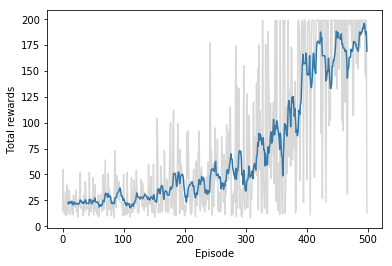

In [39]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Q losses')

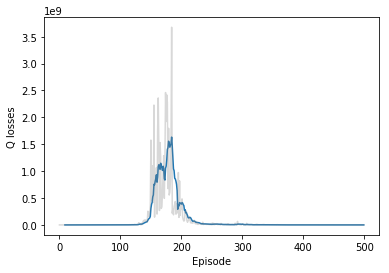

In [32]:
eps, arr = np.array(q_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Q losses')

Text(0,0.5,'G losses')

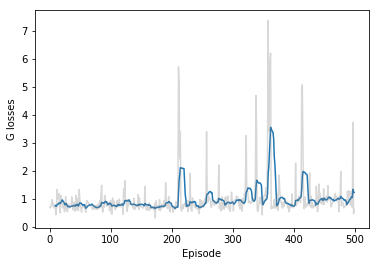

In [33]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'D losses')

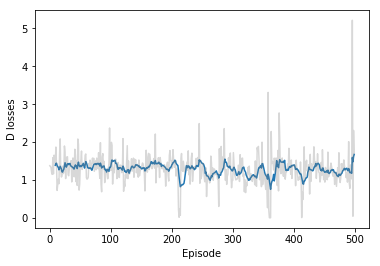

In [34]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

## Testing

Let's checkout how our trained agent plays the game.

In [35]:
test_episodes = 1
test_max_steps = 20000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000

# # # Create the env after closing it.
# env = gym.make('CartPole-v0')
# # env = gym.make('Acrobot-v1')
env.reset()

with tf.Session() as sess:
    
    # Restore/load the trained model 
    #saver.restore(sess, 'checkpoints/QGAN-cartpole.ckpt')    
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # iterations
    for ep in range(test_episodes):
        
        # number of env/rob steps
        t = 0
        while t < test_max_steps:
            
            # Rendering the env graphics
            env.render()
            
            # Get action from DQAN
            feed_dict = {model.states: state.reshape((1, *state.shape))}
            actions_logits = sess.run(model.actions_logits, feed_dict)
            action = np.argmax(actions_logits)
            
            # Take action, get new state and reward
            next_state, reward, done, _ = env.step(action)
            
            # The task is done or not;
            if done:
                t = test_max_steps
                env.reset()
                
                # Take one random step to get the pole and cart moving
                state, reward, done, _ = env.step(env.action_space.sample())
            else:
                state = next_state
                t += 1

INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt


In [93]:
# Closing the env
# WARNING: If you close, you can NOT restart again!!!!!!
env.close()

## Extending this to Deep Convolutional QAN

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.